# Reporting the largest effects

We study the problem of drawing reliable conclusions about the winner: $\hat{\imath} = \underset{i\in[m]}{\text{argmax}} \ X_i$, where $X_1,\dots,X_m$ are $m$ competing candidates.

Following [1], in this notebook we analyze which linguistic devices contribute to politeness. We draw conclusions about the most effective devices. We quantify effectiveness in two ways: (1) in terms of the Pearson correlation coefficient between the presence of a device and the perceived politeness, and (2) in terms of the logistic regression coefficient corresponding to each device, after regressing the perceived politeness on all devices. See the paper for further details.

[1] Danescu-Niculescu-Mizil, C., Sudhof, M., Jurafsky, D., Leskovec, J., & Potts, C. (2013). A computational approach to politeness with application to social factors. In 51st Annual Meeting of the Association for Computational Linguistics (pp. 250-259). ACL.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
from methods import *
from utils import *

In [2]:
data = pd.read_csv('data/politeness_dataset.csv')
features = data.to_numpy()[:,1:22].astype(float)
politeness =  data.to_numpy()[:,22].astype(float)
n, m = features.shape

## Correlation coefficient

In [3]:
r = np.array([np.corrcoef(features[:,i], politeness)[0,1] for i in range(m)])
X = fisher_transform(r)
sigma = 1 / np.sqrt(n - 3)
alpha = 0.1
ihat = np.argmax(X)

# locally simultaneous inferencce
nu = 0.01
plausible_gap = 4*norm.isf(nu/(2*m))*sigma
LSI_int = LSI_union_bound(X, [sigma] * m, plausible_gap, alpha = alpha, nu = nu)
LSI_int = np.tanh(LSI_int)

# simultaneous inference
SI_int = [np.tanh(X[ihat] - norm.isf(alpha/(2*m))*sigma), np.tanh(X[ihat] + norm.isf(alpha/(2*m))*sigma)]

# zoom correction
zoom_int = zoom_union_bound(X, [sigma]*m, alpha = alpha)
zoom_int = np.tanh(zoom_int)

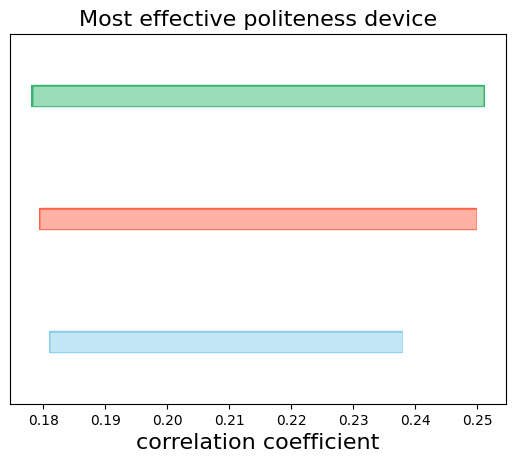

In [4]:
labels = ["simultaneous", "locally simultaneous", "zoom"]
make_intervals([SI_int, LSI_int, zoom_int], labels, "Most effective politeness device", "correlation coefficient", legend=False)
path = 'plots/politeness_corrs.pdf'
plt.savefig(path, bbox_inches='tight')

## Logistic coefficient

In [5]:
X, Sigma = logistic_stats(features, politeness)
sigmas = np.sqrt(np.diag(Sigma))
alpha = 0.1
ihat = np.argmax(X)

# conditional inference
A, b = inference_on_winner_polyhedron(m, ihat)
eta = np.zeros(m)
eta[ihat] = 1
cond_int = conditional_inference(X, Sigma, A, b, eta, alpha=alpha)

# hybrid inference
beta = 0.01
hybrid_int = hybrid_inference(X, Sigma, A, b, eta, alpha=alpha, beta=beta)

# locally simultaneous inferencce
nu = 0.01
plausible_gap = 4*norm.isf(nu/(2*m))*sigmas
LSI_int = LSI_union_bound(X, sigmas, plausible_gap, alpha = alpha, nu = nu)

# simultaneous inference
SI_int = [X[ihat] - norm.isf(alpha/(2*m))*sigmas[ihat], X[ihat] + norm.isf(alpha/(2*m))*sigmas[ihat]]

# zoom correction
zoom_int = zoom_union_bound(X, sigmas, alpha = alpha)

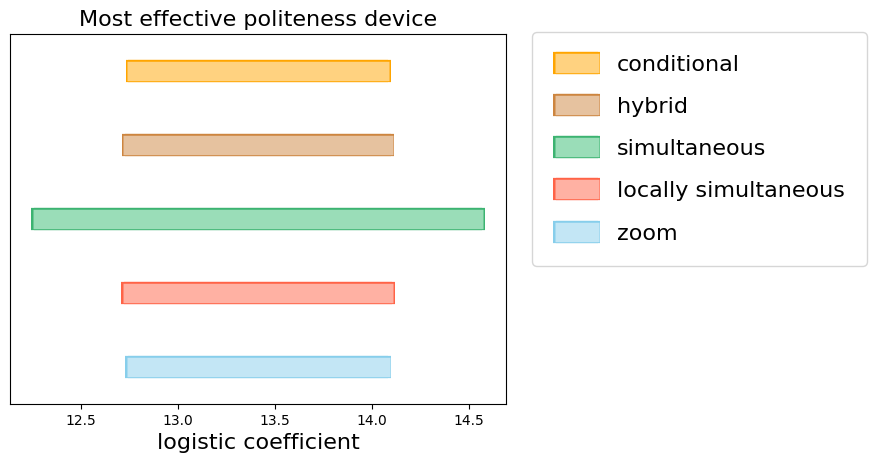

In [6]:
labels = ['conditional','hybrid','simultaneous','locally simultaneous','zoom']
plot_title = 'Most effective politeness device'
make_intervals([cond_int, hybrid_int, SI_int, LSI_int, zoom_int], labels, plot_title, "logistic coefficient", legend=True)
path = 'plots/politeness_logistic.pdf'
plt.savefig(path, bbox_inches='tight')